Automatic pdb calling has been turned ON
70028


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:143: RuntimeWarning: invalid value encountered in divide


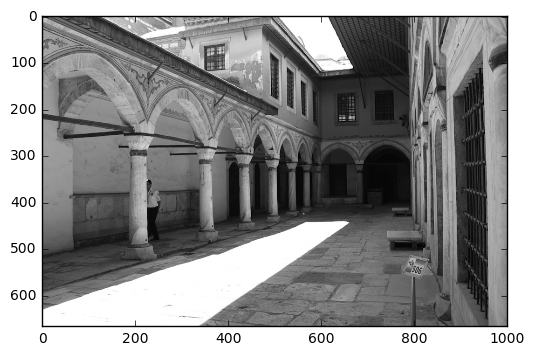

70003


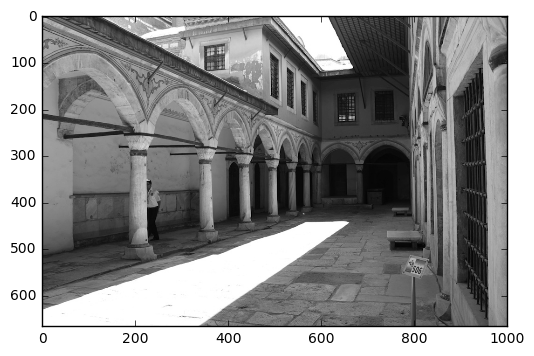

69978


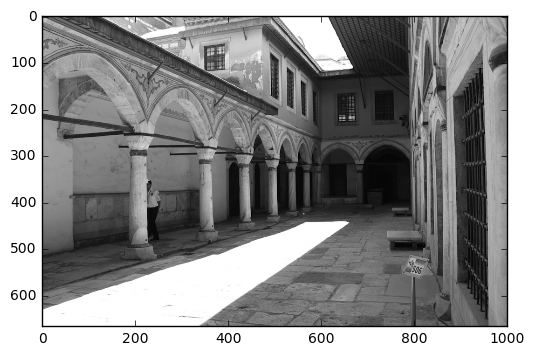

69953


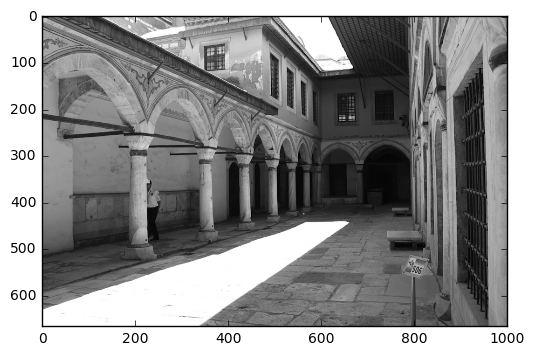

69928


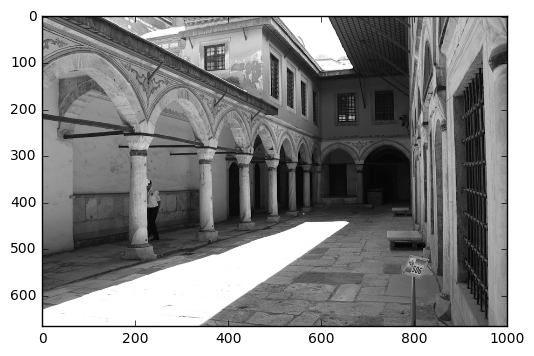

69903


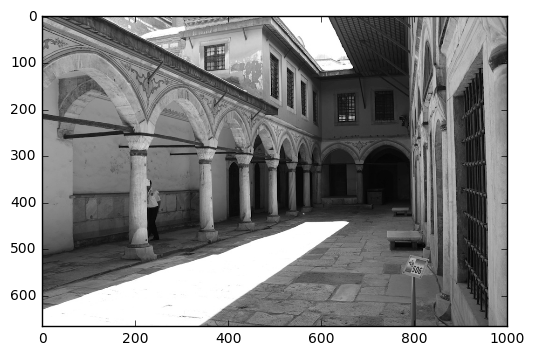

69878


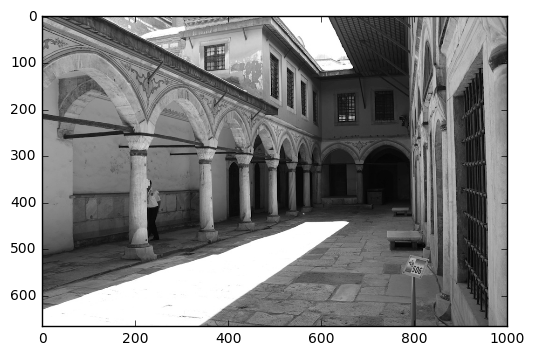

69853


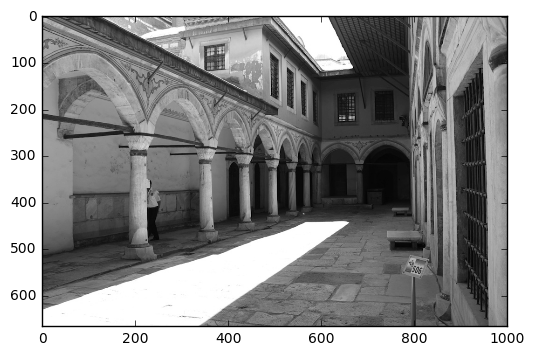

69828


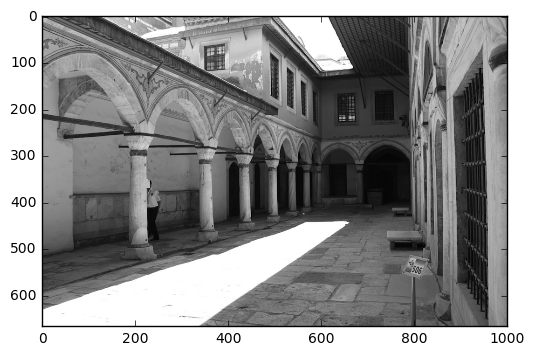

69790


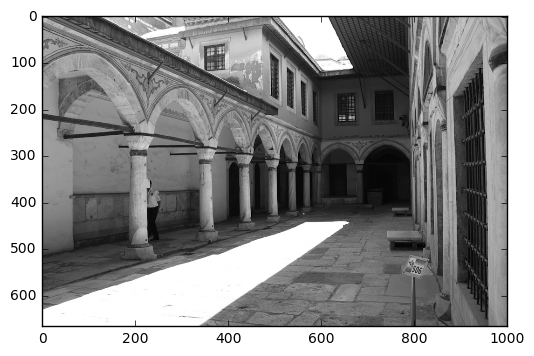

69758


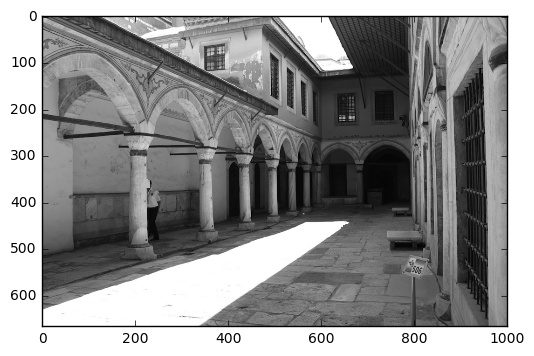

69725


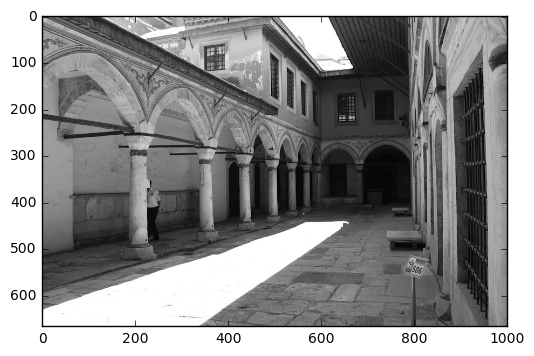

69692


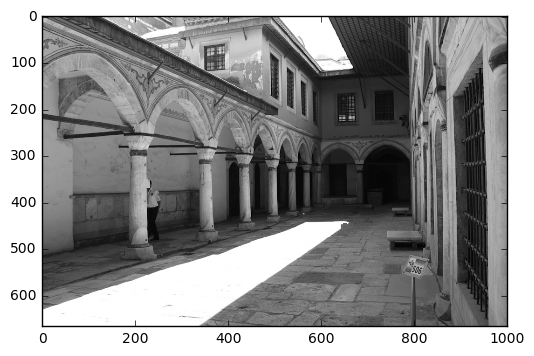

69667


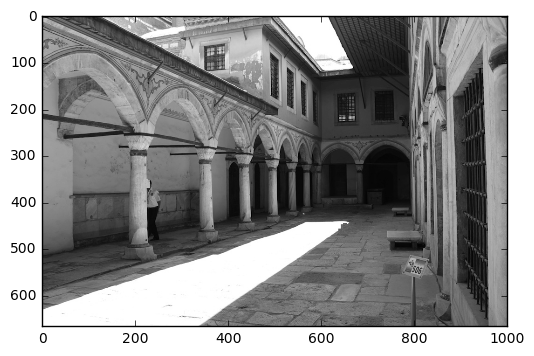

69635


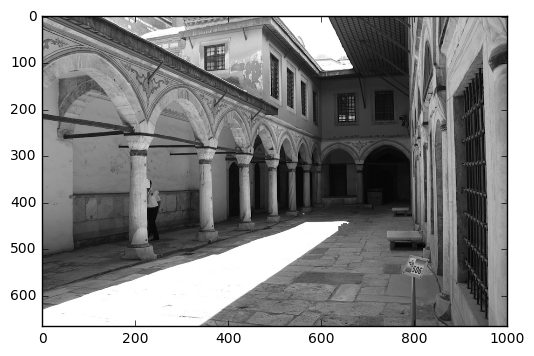

69610


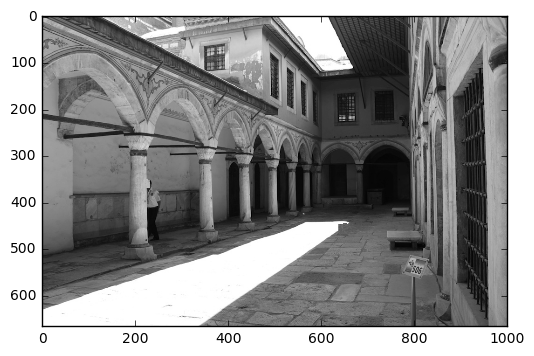

69581


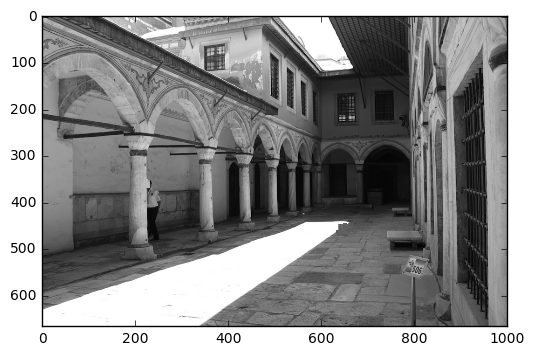

69548


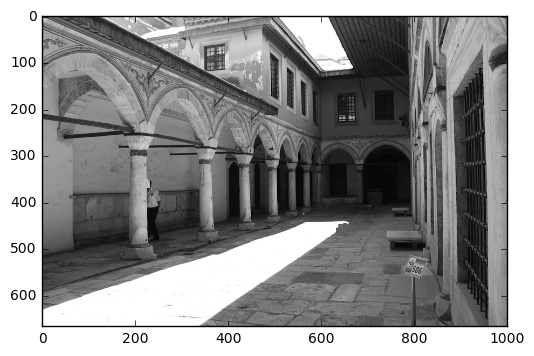

69523


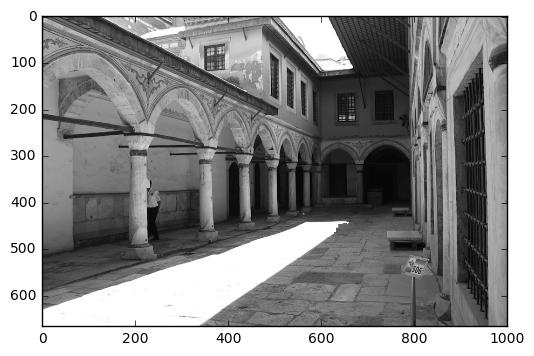

69493


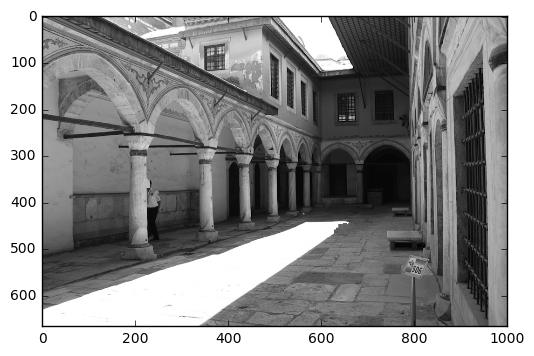

69468


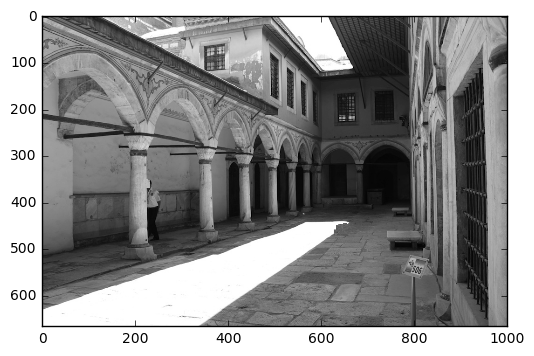

69443


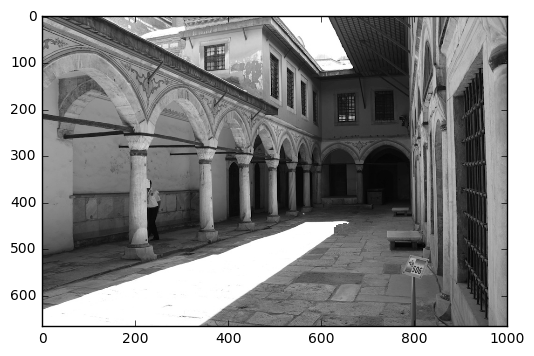

69418


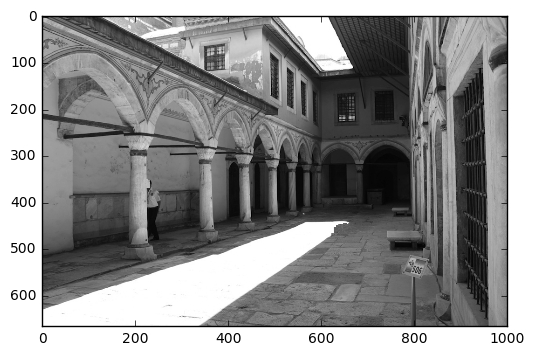

69386


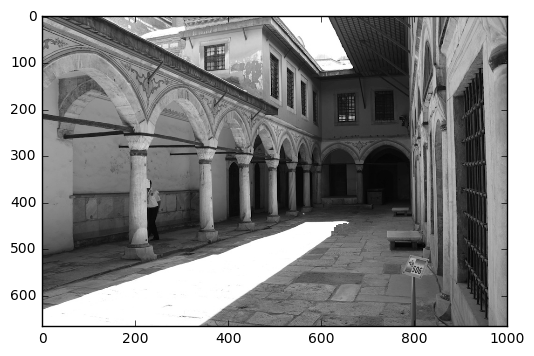

69361


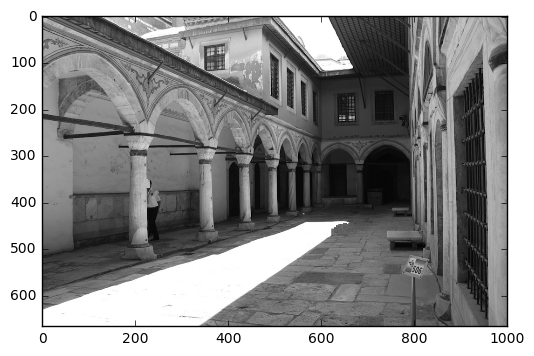

69336


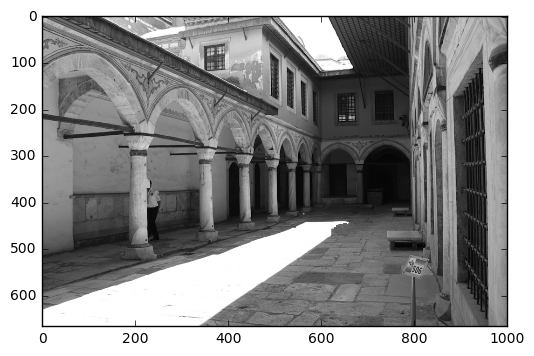

69295


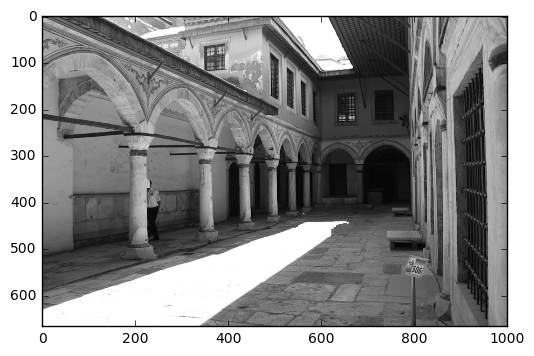

69267


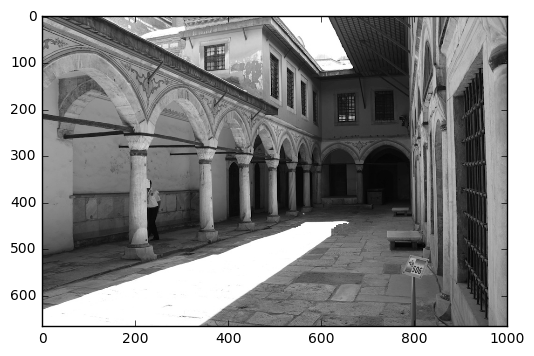

69240


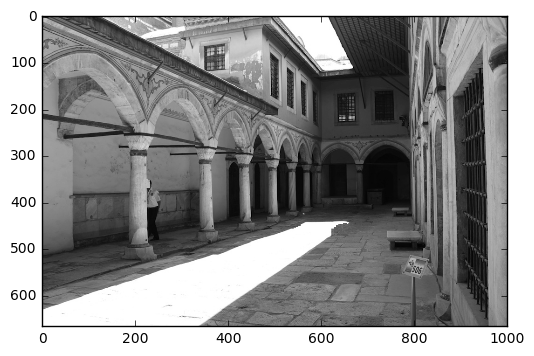

69210


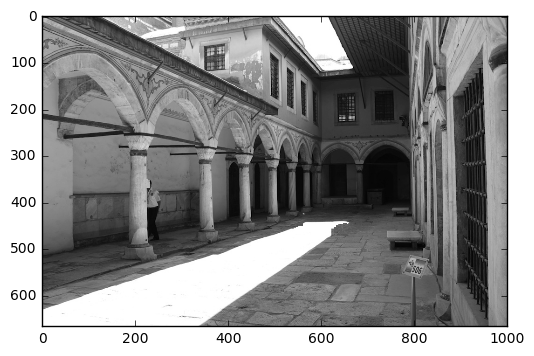

69180


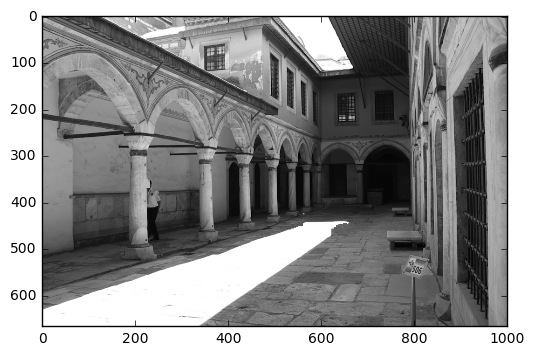

69149


In [ ]:
import numpy as np
import scipy
from skimage import morphology, io, img_as_float, color
import matplotlib.pyplot as plt
import os
import sys
import pdb
import time
from sklearn import feature_extraction as sfe
from multiprocessing import cpu_count
import cv2
plt.interactive(False)
sys.path.append("/Users/xiaolihe/Documents/Computer-Vision-534/hw2")
%pdb on

def Getboundarypoints(filled_status):
    subs_image = morphology.dilation(filled_status) - filled_status
    #     pdb.set_trace()
    [row_idxs, col_idxs] = np.where(subs_image != 0)
    # random permutation
    randidx = np.random.permutation(len(row_idxs))
    locs = [(row_idxs[idx],col_idxs[idx]) for idx in randidx]
    return locs

# get confidence value in the template window, and its filled status
def GetNeighborhoodWindow(ridx, colidx, new_img, grad_mag, conf,filled_status, win_size):
    half_win_size = win_size / 2
    row_range = range(ridx - half_win_size, ridx + half_win_size + 1)
    col_range = range(colidx - half_win_size, colidx + half_win_size + 1)
    template_img = np.zeros((win_size, win_size))
    template_grad = np.zeros((win_size, win_size))
    template_conf = np.zeros((win_size, win_size))
    template_filled_status = np.ones((win_size, win_size)) == False
    # row,column range in the img2bfilled
    if row_range[0]>=0 and col_range[0]>=0 and row_range[-1] < conf.shape[0] and col_range[-1] < conf.shape[1]:
        template_img = new_img[row_range[0]:row_range[-1]+1,col_range[0]:col_range[-1]+1]
        template_conf = conf[row_range[0]:row_range[-1]+1,col_range[0]:col_range[-1]+1]
        template_grad = grad_mag[row_range[0]:row_range[-1]+1,col_range[0]:col_range[-1]+1]
        template_filled_status = filled_status[row_range[0]:row_range[-1]+1,col_range[0]:col_range[-1]+1]
    else:
        minr_img2f = max(0, ridx - half_win_size)
        maxr_img2f = min(conf.shape[0], ridx + half_win_size + 1)
        minc_img2f = max(0, colidx - half_win_size)
        maxc_img2f = min(conf.shape[1], colidx + half_win_size + 1)
        template_img[minr_img2f-ridx+half_win_size:maxr_img2f-ridx+half_win_size,
        minc_img2f-colidx+half_win_size:maxc_img2f-colidx+half_win_size] = new_img[minr_img2f:maxr_img2f, minc_img2f:maxc_img2f]
        template_conf[minr_img2f-ridx+half_win_size:maxr_img2f-ridx+half_win_size,
        minc_img2f-colidx+half_win_size:maxc_img2f-colidx+half_win_size] = conf[minr_img2f:maxr_img2f, minc_img2f:maxc_img2f]
        template_grad[minr_img2f-ridx+half_win_size:maxr_img2f-ridx+half_win_size,
        minc_img2f-colidx+half_win_size:maxc_img2f-colidx+half_win_size] = grad_mag[minr_img2f:maxr_img2f, minc_img2f:maxc_img2f]
        template_filled_status[minr_img2f-ridx+half_win_size:maxr_img2f-ridx+half_win_size,
        minc_img2f-colidx+half_win_size:maxc_img2f-colidx+half_win_size] = filled_status[minr_img2f:maxr_img2f, minc_img2f:maxc_img2f]
    return template_img, template_grad, template_conf, template_filled_status


## Find Matches, return locations, corresponding ssd (in 1d), and corresponding pixel value
def FindMatches(template, sample_img, source_mask, ValidMask, win_size):
    Sigma = win_size / 6.4
    GaussMask = gkern(win_size, Sigma)
    mask_raw = np.multiply(ValidMask, GaussMask)
    mask_normalized = mask_raw / mask_raw.sum()
    patches_list0 = sfe.image.extract_patches_2d(sample_img, (win_size,win_size))# array, shape = (n_patches, patch_heidth)
    mask_list = sfe.image.extract_patches_2d(source_mask, (win_size,win_size))# array, shape = (n_patches, patch_heidth)
    patches_list = patches_list0[np.sum(mask_list,(1,2))==win_size*win_size]
    dist_filter = (patches_list - template)**2*mask_normalized
    SSD = np.asarray([d.sum() for d in dist_filter])
    res_loc_1d, = np.where(SSD == SSD.min())
    # pdb.set_trace()
    return patches_list[res_loc_1d][0]

def gkern(size, sigma=3.0, center=None):
	""" Make a square gaussian kernel.

    size is the length of a side of the square
    sigma is standard deviation
    can be thought of as an effective radius.
    """

	x = np.arange(0, size, 1, float)
	y = x[:, np.newaxis]

	if center is None:
		x0 = y0 = size // 2
	else:
		x0 = center[0]
		y0 = center[1]
	raw_res = 1/(2*np.pi*sigma**2)*np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2*sigma ** 2))
	return raw_res/raw_res.sum()

# filled in target region with the best match, and update correspoinding target_mask, source_mask, confidence value
def filledin(ploc, win_size, new_img, conf, target_mask, source_mask, bestmactchpatch):
    half_win_size = win_size/2
    row_range = range(ploc[0] - half_win_size, ploc[0] + half_win_size + 1)
    col_range = range(ploc[1] - half_win_size, ploc[1] + half_win_size + 1)
    for r in row_range:
        for c in col_range:
            if target_mask[r,c] and r >=0 and c>=0 and r<new_img.shape[0] and c< new_img.shape[1]:
                new_img[r,c] = bestmactchpatch[r-ploc[0],c-ploc[1]]
                target_mask[r,c] = False
                source_mask[r,c] = True
                conf[r,c] = conf[r-ploc[0], c-ploc[1]]


def objectremoval(filename, filetype, maskname, win_size = 9):
    # read sample image
    t = time.time()
    img_sample0 = io.imread(os.getcwd() + '/Documents/Computer-Vision-534/hw2/Assignment-II-images/' + filename + filetype)
#     img_sample0 = io.imread(os.getcwd() + '/Assignment-II-images/' + filename + filetype)
    img_sample0 = color.rgb2gray(img_sample0) # rgb to gray level
    img = img_as_float(img_sample0) # convert image to 0-1 values
    new_img = np.copy(img)
    alpha = 1
    ## load mask
    mask = img_as_float(color.rgb2gray(io.imread(os.getcwd() + '/Documents/Computer-Vision-534/hw2/Assignment-II-images/' + maskname + '.jpg')))
#     mask = img_as_float(color.rgb2gray(io.imread(os.getcwd() + '/Assignment-II-images/' + maskname + '.jpg')))
    mask = mask.astype('bool') # target region: 1;  else: 0
#     plt.imshow(mask,'gray')
#     plt.show()
    target_mask = mask
    source_mask = mask == False
    # P = C*D
    # initialize confidence term and data term
    conf = (source_mask).astype('double')
    D = (source_mask).astype('double')
    # print conf
    while target_mask.any():
        print target_mask.sum()
        ## find pixels on the contour
        p_list = Getboundarypoints(np.logical_not(mask)) #(x,y) location
        grad_x, grad_y = np.gradient(img)
        grad_x = np.array(grad_x)
        grad_y = np.array(grad_y)
        grad_mag = np.sqrt(np.array(grad_x)**2 + np.array(grad_y)**2)
        Prior = []
        for point in p_list:
            ## Computing patch priorities
            template, template_gradient, template_c, template_filled_status = GetNeighborhoodWindow(point[0], point[1],new_img, grad_mag, conf, source_mask, win_size)
            # C (C(q) within template, and the area of the template)
            conf[point] = (template_c*template_filled_status).sum()/(win_size*win_size)
            # Data (max gradient, normal direction n_p within template)
            max_gradient = template_gradient.max()
            norm_p = [grad_x[point],grad_y[point]]
            norm_p = norm_p/np.linalg.norm(norm_p)
            norm_p = np.array([0,0]) if np.isnan(norm_p[0]) or np.isnan(norm_p[1]) else norm_p
            D[point] =  np.linalg.norm(max_gradient*norm_p)/alpha
            # priority
            # Prior[point]= conf[point]*D[point]
            Prior.append(conf[point]*D[point])
        ## Propagating texture and structure information
        # find max pirority patch
        Prior = np.array(Prior)
        priority_idx, = np.where(Prior == Prior.max())
        priority_ploc = p_list[priority_idx[np.random.randint(0, len(priority_idx))]]
        template_img, template_gradient, template_c, template_filled_status = GetNeighborhoodWindow(priority_ploc[0], priority_ploc[1],new_img, grad_mag, conf, source_mask, win_size)
        BestMatch_patch = FindMatches(template_img, new_img, source_mask, template_filled_status, win_size)
        # fill in the patch and Updating confidence values.
        filledin(priority_ploc, win_size,new_img, conf, target_mask, source_mask, BestMatch_patch)
        plt.imshow(new_img,'gray')
        plt.show()

objectremoval('test_im3','.jpg','test_im3_mask', win_size = 9)





In [20]:
filename = 'test_im3'
maskname = 'test_im3_mask'
img_sample0 = io.imread(os.getcwd() + '/Documents/Computer-Vision-534/hw2/Assignment-II-images/' + filename + '.jpg')
img_sample0 = color.rgb2gray(img_sample0) # rgb to gray level
img = img_as_float(img_sample0) # convert image to 0-1 values
## load mask
mask = img_as_float(color.rgb2gray(io.imread(os.getcwd() + '/Documents/Computer-Vision-534/hw2/Assignment-II-images/' + maskname + '.jpg')))
mask = mask.astype('bool') # target region: 1;  else: 0
print np.logical_not(mask)

[[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [False False False ...,  True  True  True]
 [False False False ...,  True  True  True]
 [False False False ...,  True  True  True]]


In [37]:

tmpx,tmpy = np.gradient(np.array([[1, 2, 6], [3, 4, 5]], dtype=np.float))
p_list = [(1,1),(0,2)]
print tmpx
print tmpy
mag_tmp=np.sqrt(np.array(tmpx)**2+np.array(tmpy)**2)
tmp_norm = [np.array(tmpx)[p_list],np.array(tmpy)[p_list]]
print mag_tmp.max()
print tmp_norm

[[ 2.  2. -1.]
 [ 2.  2. -1.]]
[[ 1.   2.5  4. ]
 [ 1.   1.   1. ]]
4.12310562562
[array([ 2., -1.]), array([ 1.,  1.])]


In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.misc import face
from scipy.linalg import norm
from skimage import measure
import networkx as nx
from sklearn import cluster
import threading
import Queue
import time
from multiprocessing import cpu_count
import cv2
import numpy as np
import scipy
from skimage import morphology, io, img_as_float, color
import matplotlib.pyplot as plt
import os
import sys
import pdb
import time
from sklearn import feature_extraction as sfe

%pdb on
%pylab qt
import matplotlib.pyplot as plt
import numpy as np
filename = 'test_im3.jpg'
img_sample0 = io.imread(os.getcwd() + '/Documents/Computer-Vision-534/hw2/Assignment-II-images/' + filename)
img_sample0 = color.rgb2gray(img_sample0) # rgb to gray level
img_sample = img_as_float(img_sample0) # convert image to 0-1 values

img = img_sample
# plt.imshow(img)
# plt.axis("off")
# plt.show()
boxes = []
counter = 0
while True:
    def on_mouse(event, x, y, flags, params):
        global boxes, img, counter

        if event == cv2.EVENT_LBUTTONDOWN:
            #print 'Start Mouse Position: '+str(x)+', '+str(y)
            boxes.append((x, y))

        elif event == cv2.EVENT_LBUTTONUP:
            #print 'End Mouse Position: '+str(x)+', '+str(y)
            ebox = (x, y)
            boxes.append((x, y))
#             cv2.rectangle(img, boxes[0], boxes[1], [0, 0, 0], thickness=-1)
            cv2.fillConvexPoly(img, np.array(boxes),255)
            boxes = []
            counter += 1

    cv2.namedWindow('Image')
    cv2.setMouseCallback('Image', on_mouse, 0)
    cv2.imshow('Image',img)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        %pylab inline
        plt.imshow(img,'gray')
        plt.show()
        pdb.set_trace()
        cv2.imwrite("created_.png", img)
        break